<a href="https://colab.research.google.com/github/jacr2006/android-tflitemodel-drowsiness-detection/blob/master/data_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install xmltodict

In [9]:
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from keras.models import load_model

Using TensorFlow backend.


In [0]:
PATH_DRIVE = '/content/drive/My Drive/Proyectos Nuevos/ML/multiclass_landmark_keras_cnn/'
PATH_DATASET = 'ibug_300W_large_face_landmark_dataset/'
MODEL_PATH = PATH_DRIVE+'models/model2.h5'

pathXml = PATH_DRIVE + PATH_DATASET + 'labels_ibug_300W_test.xml'# archivo con los datos de prueba
with open(pathXml, 'r') as file:
  dict = xmltodict.parse(file.read())# lectura del archivo xml y conversion a diccionario

In [22]:
IMG_NUM=500
pathImg = dict['dataset']['images']['image'][IMG_NUM]['@file']# ruta de la imagen

x=[]
y=[]
for i in range(68):# marcas faciales de la imagen
  x.append( int(dict['dataset']['images']['image'][IMG_NUM]['box']['part'][i]['@x']) )
  y.append( int(dict['dataset']['images']['image'][IMG_NUM]['box']['part'][i]['@y']) )

left = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@left'] )# rectangulo sobre el rostro, asi que no es necesario usar ningun algoritmo de deteccion de rostros
top = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@top'] )
width = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@width'] )
height = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@height'] )

print(pathImg)
print(left)
print(top)
print(width)
print(height)


lfpw/trainset/image_0579.png
226
122
105
105


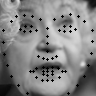

In [26]:
IMG_WIDTH = 96# tamaño de a imagen de entrada de la CNN
IMG_HEIGHT = 96
IMG_CHANNEL = 1# imagen en escala de grises
N_LANDMARK = 68# numero de marcas faciales

MEAN = 48.55575925239583# valor medio de la normalizacion de las marcas faciales
RANGE = 146.0#rango de la normalizacion de las marcas faciales

img=cv2.imread( PATH_DRIVE + PATH_DATASET + pathImg )
cropImg = img[top:top+height, left:left+width]# recorte de la imagen al tamaño de la region de interes (ROI)

xcrop=[]
ycrop=[]
for i in range(68):# escalado de las marcas faciales a la ROI
  xcrop.append( x[i]-left )
  ycrop.append( y[i]-top )

mcrop=list(zip(xcrop,ycrop))

rezImg = cv2.resize( cropImg, ( IMG_WIDTH, IMG_HEIGHT ) )# escalado de la imagen usando opencv
grayImg = cv2.cvtColor( rezImg, cv2.COLOR_BGR2GRAY )# conversion de RGB a escala de grises con opencv.
rshImg = grayImg.reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)#reordenamiento de la imagen de acuerdo a la entrada requerida por la CNN
rshImg = rshImg/255.0#normalizacion de la imagen, entre (0,1). De acuerdo al entrenamiento

_model = load_model(MODEL_PATH)
res=_model.predict(rshImg)# inferencia del modelo

res=res.reshape( 1, N_LANDMARK, 2 )#desnormalizacion de la inferencia
marks = ( res * RANGE ) + MEAN

for i in range(N_LANDMARK):
  cv2.circle( grayImg, ( marks[0,i,0], marks[0,i,1] ), 1, (0, 0, 255), -1 )#dibuja la inferencia sobre la imagen

xrez=[]
yrez=[]
for i in range( 68 ):# escalado de las marcas faciales en la misma proporcion de la imagen
  xrez.append( int(xcrop[i]*IMG_WIDTH/cropImg.shape[0]) )
  yrez.append( int(ycrop[i]*IMG_HEIGHT/cropImg.shape[1]) )

marks=zip(xrez,yrez)

#for (i, j) in marks:
#  cv2.circle(grayImg, (i,j), 1, (255, 0, 0), -1)#dibuja las marcas faciales reales sobre la imagen

cv2_imshow(grayImg)# despliegue de la imagen escalada y en escala de grises